
# Week 6 In‑Class Lab — Agricultural Productivity
Topics covered: **Dummy coding**, **Missing data**, **Transformations (log, sqrt)**, quick **model comparison**.

**Dataset:** `agri_productivity.psv` (pipe‑delimited). Each row is one field in a season.

**Learning goals**
1. Clean a categorical variable with messy values (`Irrigation_Method`) and dummy‑code categories.
2. Examine and impute missing data (mode vs. mean vs. simple model‑based imputation).
3. Identify skew and apply **log** (Fertilizer) and **sqrt** (Rainfall) transforms.
4. Fit OLS models and interpret coefficients with and without transformations.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [2]:

# Load the pipe-delimited dataset
path = r"agri_productivity.csv"
df = pd.read_csv(path, sep=",")
df.head()


,Field_ID,Crop_Type,Soil_Quality,Irrigation_Method,Fertilizer_Amount_kg_per_acre,Rainfall_inches,Pesticide_Use_liters_per_acre,Yield_tons_per_acre
0,1001,Corn,Good,NaN,20.89,11.48,2.01,3.843
1,1002,Corn,Fair,NaN,250.19,20.41,2.20,4.570
2,1003,Corn,Good,NaN,39.50,22.14,2.36,3.852
3,1004,Corn,Poor,NaN,96.90,9.59,1.89,2.911
4,1005,Corn,Poor,NaN,75.29,11.85,1.93,3.118



## 1) Quick EDA
- Inspect types and missingness
- Frequency tables for categoricals


In [3]:

df.info()
print("\nMissing values by column:")
print(df.isna().sum())

print("\nValue counts: Crop_Type")
print(df["Crop_Type"].value_counts(dropna=False))

print("\nValue counts: Soil_Quality")
print(df["Soil_Quality"].value_counts(dropna=False))

print("\nValue counts: Irrigation_Method (raw, messy)")
print(df["Irrigation_Method"].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Field_ID                       300 non-null    int64  
 1   Crop_Type                      300 non-null    object 
 2   Soil_Quality                   300 non-null    object 
 3   Irrigation_Method              131 non-null    object 
 4   Fertilizer_Amount_kg_per_acre  300 non-null    float64
 5   Rainfall_inches                300 non-null    float64
 6   Pesticide_Use_liters_per_acre  285 non-null    float64
 7   Yield_tons_per_acre            300 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 18.9+ KB

Missing values by column:
Field_ID                           0
Crop_Type                          0
Soil_Quality                       0
Irrigation_Method                169
Fertilizer_Amount_kg_per_acre      0
Rainfall_inches      

In [6]:
df['Crop_Type'].value_counts()

Crop_Type
Corn        138
Soybeans     96
Wheat        66
Name: count, dtype: int64


## 2) Clean messy categorical values (Irrigation_Method)
Normalize case/spacing and collapse known variants.


In [7]:

def normalize_irrigation(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # collapse common variants
    upper = s.upper()
    if upper == "SPRINKLER":
        return "Sprinkler"
    if upper == "DRIP":
        return "Drip"
    if upper == "NONE":
        return "None"
    # Title-case fallback
    return s.title()

df["Irrigation_Method_clean"] = df["Irrigation_Method"].apply(normalize_irrigation)
print(df["Irrigation_Method_clean"].value_counts(dropna=False))


Irrigation_Method_clean
NaN          169
Sprinkler     80
Drip          48
None           3
Name: count, dtype: int64



## 3) Visualize skew (decide transformations)
- **Fertilizer_Amount_kg_per_acre** → expect right skew → **log transform**
- **Rainfall_inches** → right skew → **sqrt transform**


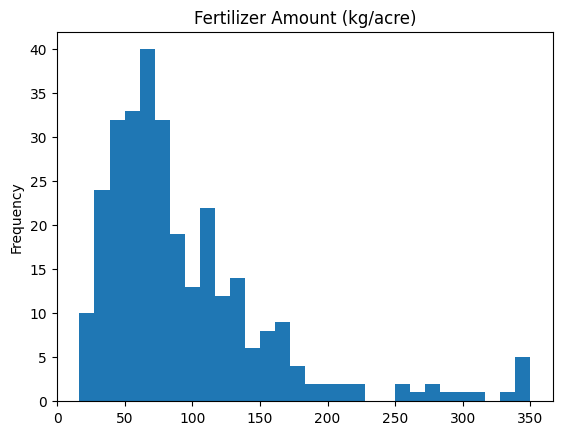

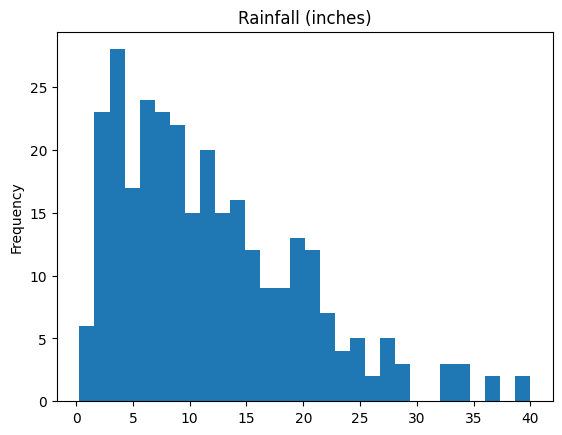

In [20]:

fig, ax = plt.subplots()
df["Fertilizer_Amount_kg_per_acre"].plot(kind="hist", bins=30, ax=ax, title="Fertilizer Amount (kg/acre)")
plt.show()

fig, ax = plt.subplots()
df["Rainfall_inches"].plot(kind="hist", bins=30, ax=ax, title="Rainfall (inches)")
plt.show()


In [21]:

df["log_fertilizer"] = np.log1p(df["Fertilizer_Amount_kg_per_acre"])
df["sqrt_rainfall"]  = np.sqrt(df["Rainfall_inches"])
df[["Fertilizer_Amount_kg_per_acre","log_fertilizer","Rainfall_inches","sqrt_rainfall"]].head()


,Fertilizer_Amount_kg_per_acre,log_fertilizer,Rainfall_inches,sqrt_rainfall
0,20.89,3.086030,11.48,3.388215
1,250.19,5.526210,20.41,4.517743
2,39.50,3.701302,22.14,4.705316
3,96.90,4.583947,9.59,3.096773
4,75.29,4.334542,11.85,3.442383



## 4) Handle missing data
Compare simple strategies:
- **Drop rows** with any missing (baseline).
- **Mode** imputation for `Irrigation_Method_clean` (categorical) and **mean** for `Pesticide_Use_liters_per_acre`.
- (Optional) **IterativeImputer** for numeric `Pesticide_Use_liters_per_acre` using other predictors.


In [22]:

cols_needed = ["Crop_Type","Soil_Quality","Irrigation_Method_clean",
               "Fertilizer_Amount_kg_per_acre","Rainfall_inches",
               "Pesticide_Use_liters_per_acre","Yield_tons_per_acre",
               "log_fertilizer","sqrt_rainfall"]

df_drop = df[cols_needed].dropna().copy()
len(df), len(df_drop)


(300, 125)

In [23]:

df_imp = df.copy()

# Categorical: mode for irrigation
mode_irr = df_imp["Irrigation_Method_clean"].mode().iloc[0]
df_imp["Irrigation_Method_imp"] = df_imp["Irrigation_Method_clean"].fillna(mode_irr)

# Numeric: mean for pesticide
mean_pest = df_imp["Pesticide_Use_liters_per_acre"].mean()
df_imp["Pesticide_imp"] = df_imp["Pesticide_Use_liters_per_acre"].fillna(mean_pest)

# Keep transformed columns
df_imp["log_fertilizer"] = df_imp["log_fertilizer"]
df_imp["sqrt_rainfall"]  = df_imp["sqrt_rainfall"]

df_imp[["Irrigation_Method_clean","Irrigation_Method_imp","Pesticide_Use_liters_per_acre","Pesticide_imp"]].head()


,Irrigation_Method_clean,Irrigation_Method_imp,Pesticide_Use_liters_per_acre,Pesticide_imp
0,NaN,Sprinkler,2.01,2.01
1,NaN,Sprinkler,2.20,2.20
2,NaN,Sprinkler,2.36,2.36
3,NaN,Sprinkler,1.89,1.89
4,NaN,Sprinkler,1.93,1.93


In [24]:

# Optional: Iterative imputation for pesticide using other numeric predictors
num_cols = ["Pesticide_Use_liters_per_acre",
            "Fertilizer_Amount_kg_per_acre","Rainfall_inches","Yield_tons_per_acre"]
imp = IterativeImputer(random_state=5740, sample_posterior=True, max_iter=10)
df_iter = df.copy()
df_iter[num_cols] = imp.fit_transform(df_iter[num_cols])

# Keep a comparison column
df_iter["Pesticide_iter_imp"] = df_iter["Pesticide_Use_liters_per_acre"]
df_iter[["Pesticide_Use_liters_per_acre","Pesticide_iter_imp"]].head(10)


,Pesticide_Use_liters_per_acre,Pesticide_iter_imp
0,2.010000,2.010000
1,2.200000,2.200000
2,2.360000,2.360000
3,1.890000,1.890000
4,1.930000,1.930000
5,1.880000,1.880000
6,1.668332,1.668332
7,0.580000,0.580000
8,1.940000,1.940000
9,1.520000,1.520000



## 5) Dummy coding
- `Crop_Type` (Corn as reference via `drop_first=True`).
- `Irrigation_Method` (None as reference automatically if alphabetically first; verify after get_dummies).
- `Soil_Quality` is **ordinal**: encode as ordered 1 < 2 < 3.


In [25]:

# Ordinal encode Soil_Quality
soil_map = {"Poor":1, "Fair":2, "Good":3}

def prep_design(df_like, use_iter=True):
    X = df_like.copy()
    print(X.columns)
    X["Soil_Quality_ord"] = X["Soil_Quality"].map(soil_map)
    # choose pesticide from simple vs iterative
    if use_iter:
        pest_col = "Pesticide_Use_liters_per_acre"  # already imputed in df_iter
    # build design matrix with dummies
    des = pd.DataFrame({
        "Yield": X["Yield_tons_per_acre"],
        "Soil_Quality_ord": X["Soil_Quality_ord"],
        "log_fertilizer": X["log_fertilizer"],
        "sqrt_rainfall": X["sqrt_rainfall"],
        "Pesticide": X[pest_col]
    })
    crop_dum = pd.get_dummies(X["Crop_Type"], prefix="Crop", drop_first=True)
    irr_dum  = pd.get_dummies(X.get("Irrigation_Method_imp", X.get("Irrigation_Method_clean")), prefix="Irr", drop_first=True)
    des = pd.concat([des, crop_dum, irr_dum], axis=1)
    return des

des_drop = prep_design(df_drop)  # dropped rows (complete cases)
des_imp  = prep_design(df_imp)   # simple imputation
des_iter = df_iter.copy()
des_iter["Irrigation_Method_imp"] = df_imp["Irrigation_Method_imp"]  # reuse categorical mode
des_iter["log_fertilizer"] = df["log_fertilizer"]
des_iter["sqrt_rainfall"]  = df["sqrt_rainfall"]

des_iter = prep_design(des_iter, use_iter=True)

des_drop.head()


Index(['Crop_Type', 'Soil_Quality', 'Irrigation_Method_clean', 'Fertilizer_Amount_kg_per_acre', 'Rainfall_inches',
       'Pesticide_Use_liters_per_acre', 'Yield_tons_per_acre', 'log_fertilizer', 'sqrt_rainfall'],
      dtype='object')
Index(['Field_ID', 'Crop_Type', 'Soil_Quality', 'Irrigation_Method', 'Fertilizer_Amount_kg_per_acre',
       'Rainfall_inches', 'Pesticide_Use_liters_per_acre', 'Yield_tons_per_acre', 'Irrigation_Method_clean',
       'log_fertilizer', 'sqrt_rainfall', 'Irrigation_Method_imp', 'Pesticide_imp'],
      dtype='object')
Index(['Field_ID', 'Crop_Type', 'Soil_Quality', 'Irrigation_Method', 'Fertilizer_Amount_kg_per_acre',
       'Rainfall_inches', 'Pesticide_Use_liters_per_acre', 'Yield_tons_per_acre', 'Irrigation_Method_clean',
       'log_fertilizer', 'sqrt_rainfall', 'Pesticide_iter_imp', 'Irrigation_Method_imp'],
      dtype='object')


,Yield,Soil_Quality_ord,log_fertilizer,sqrt_rainfall,Pesticide,Crop_Soybeans,Crop_Wheat,Irr_None,Irr_Sprinkler
5,3.680,3,4.026244,4.496665,1.88,False,True,False,True
7,3.099,1,5.285333,3.160696,0.58,False,True,False,True
11,3.040,2,4.040768,1.780449,0.89,True,False,False,False
12,3.462,2,4.262962,2.559297,1.28,True,False,False,True
13,4.007,3,3.953549,3.648287,1.05,True,False,False,False



## 6) Fit and compare models
- **Model A (complete cases, no transforms)** for a baseline.
- **Model B (simple imputation + transforms)** — recommended final.
- **Model C (iterative imputation for numeric)** — optional comparison.


In [26]:

# Model A: Complete cases, but mistakenly use raw fertilizer & rainfall to show effect of transforms later
A = df_drop.copy()
A = pd.concat([A, pd.get_dummies(A["Crop_Type"], prefix="Crop", drop_first=True),
                  pd.get_dummies(A["Irrigation_Method_clean"], prefix="Irr", drop_first=True)], axis=1)
formulaA = "Yield_tons_per_acre ~ Soil_Quality.map({'Poor':1,'Fair':2,'Good':3}) + Fertilizer_Amount_kg_per_acre + Rainfall_inches + Pesticide_Use_liters_per_acre + Crop_Soybeans + Crop_Wheat + Irr_Sprinkler"
resA = smf.ols(formula=formulaA, data=A).fit()
print(resA.summary())


                             OLS Regression Results                            
Dep. Variable:     Yield_tons_per_acre   R-squared:                       0.343
Model:                             OLS   Adj. R-squared:                  0.304
Method:                  Least Squares   F-statistic:                     8.744
Date:                 Sun, 28 Sep 2025   Prob (F-statistic):           1.30e-08
Time:                         21:24:44   Log-Likelihood:                -73.078
No. Observations:                  125   AIC:                             162.2
Df Residuals:                      117   BIC:                             184.8
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [27]:

# Model B: Simple imputation + transforms
B = des_imp.rename(columns={"Yield":"Yield_tons_per_acre"}).copy()
# Build formula dynamically based on available columns
rhs = [c for c in B.columns if c != "Yield_tons_per_acre"]
formulaB = "Yield_tons_per_acre ~ " + " + ".join(rhs)
resB = smf.ols(formula=formulaB, data=B).fit()
print(resB.summary())


                             OLS Regression Results                            
Dep. Variable:     Yield_tons_per_acre   R-squared:                       0.342
Model:                             OLS   Adj. R-squared:                  0.323
Method:                  Least Squares   F-statistic:                     17.92
Date:                 Sun, 28 Sep 2025   Prob (F-statistic):           1.63e-21
Time:                         21:24:44   Log-Likelihood:                -194.30
No. Observations:                  285   AIC:                             406.6
Df Residuals:                      276   BIC:                             439.5
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [28]:

# Model C: Iterative imputation for numeric (optional)
C = des_iter.rename(columns={"Yield":"Yield_tons_per_acre"}).copy()
rhs = [c for c in C.columns if c != "Yield_tons_per_acre"]
formulaC = "Yield_tons_per_acre ~ " + " + ".join(rhs)
resC = smf.ols(formula=formulaC, data=C).fit()
print(resC.summary())


                             OLS Regression Results                            
Dep. Variable:     Yield_tons_per_acre   R-squared:                       0.337
Model:                             OLS   Adj. R-squared:                  0.319
Method:                  Least Squares   F-statistic:                     18.53
Date:                 Sun, 28 Sep 2025   Prob (F-statistic):           2.07e-22
Time:                         21:24:44   Log-Likelihood:                -208.62
No. Observations:                  300   AIC:                             435.2
Df Residuals:                      291   BIC:                             468.6
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           


### Compare fit
Look at **R²**, **AIC**, sample size (df_resid), and check how coefficient magnitudes/SEs change across approaches.


In [29]:

def fit_stats(name, res):
    return pd.Series({
        "Model": name,
        "R2": res.rsquared,
        "Adj_R2": res.rsquared_adj,
        "AIC": res.aic,
        "n": int(res.nobs)
    })

stats = pd.concat([
    fit_stats("A_complete_raw", resA),
    fit_stats("B_simple_imp_transforms", resB),
    fit_stats("C_iterative_imp_transforms", resC),
], axis=1).T.reset_index(drop=True)

stats


,Model,R2,Adj_R2,AIC,n
0,A_complete_raw,0.343463,0.304183,162.155946,125
1,B_simple_imp_transforms,0.34182,0.322742,406.598223,285
2,C_iterative_imp_transforms,0.337473,0.31926,435.2341,300



## 7) Residual diagnostics (Model B)
- Residuals vs Fitted
- QQ Plot


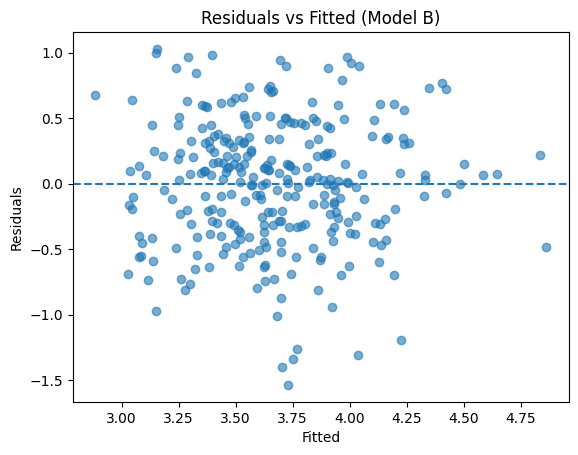

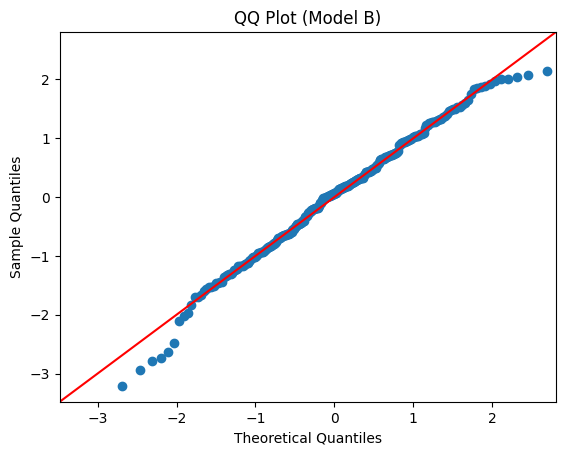

In [30]:

fitted = resB.fittedvalues
resid  = resB.resid

fig, ax = plt.subplots()
ax.scatter(fitted, resid, alpha=0.6)
ax.axhline(0, linestyle="--")
ax.set_xlabel("Fitted")
ax.set_ylabel("Residuals")
ax.set_title("Residuals vs Fitted (Model B)")
plt.show()

fig = sm.qqplot(resB.resid, line="45", fit=True)
plt.title("QQ Plot (Model B)")
plt.show()



## 8) Interpreting coefficients (Model B)
- Dummy‑coded **Crop_Type**: coefficients represent differences vs the **reference** category (the one not shown because of `drop_first=True`).  
- Dummy‑coded **Irrigation** similarly.  
- **Soil_Quality_ord** is a one‑unit increase from Poor→Fair→Good.  
- **log_fertilizer**: a 1‑unit increase is roughly an e‑fold (≈2.718×) increase in fertilizer amount; interpret effect as change in yield per log‑unit.  
- **sqrt_rainfall**: interpret per square‑root‑inch increase; used to stabilize variance / linearize relationship.



### Deliverables / Discussion prompts
1. Re‑run Model B with **Corn** filtered out. How do the crop effects change?
2. Try **mode vs. median** for pesticide imputation. Does it matter here?
3. Add an interaction: `Soil_Quality_ord * Irr_Sprinkler`. Is there evidence of effect modification?
